# Create GEANT4 Input ROOT Files for Cosmic Muons - Short Version

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
# Load the cosmic flux file
cosmics = np.load('/Users/yuntse/data/coherent/preLArTPC/cosmic/CosmicFlux.npy')
len(cosmics)

6

In [3]:
Lmax = len(cosmics[0])
Lmax

10000000

## Determine the fractions from the six phase space (p, costh) regions

In [4]:
# Analytical cosmic ray flux from the paper
def dI_dpdcosth(costh, p):
    return 18/(p*costh+145)* (1./np.power(p+2.7/costh, 2.7))* (p+5)/(p+5/costh)

In [5]:
# The fraction of the six (p, costh) areas
pmins = np.array([1., 1., 2., 2., 4., 10.])
pmaxs = np.array([2., 2., 4., 4., 10., 10000.])
costhmins = np.array([0., 0.5, 0., 0.5, 0., 0.])
costhmaxs = np.array([0.5, 1., 0.5, 1., 1., 1.])
Is = np.array([
              integrate.dblquad(dI_dpdcosth, pmin, pmax, costhmin, costhmax)
              for pmin, pmax, costhmin, costhmax in zip(pmins, pmaxs, costhmins, costhmaxs) ])
Is

array([[4.64644323e-05, 1.18104498e-14],
       [6.57350877e-04, 9.54998544e-18],
       [6.62890781e-05, 2.49271358e-14],
       [6.63691325e-04, 7.36845390e-18],
       [7.13559963e-04, 2.99131045e-11],
       [4.79661416e-04, 3.34803625e-09]])

In [6]:
Imax = Is[:,0].max()
L = np.round(Is[:,0]*Lmax/Imax)
Lrounded = L.astype(int)
L, Lrounded

(array([  651164.,  9212272.,   928991.,  9301129., 10000000.,  6722090.]),
 array([  651164,  9212272,   928991,  9301129, 10000000,  6722090]))

In [7]:
cosmics[0], cosmics[0][0:3]

(array([[1.69026559, 0.47500469],
        [1.62594644, 0.47681492],
        [1.63929539, 0.4734408 ],
        ...,
        [1.06612328, 0.4722691 ],
        [1.18713756, 0.3521335 ],
        [1.03874213, 0.39006242]]),
 array([[1.69026559, 0.47500469],
        [1.62594644, 0.47681492],
        [1.63929539, 0.4734408 ]]))

In [8]:
cosmicsAll = np.concatenate([ cosmics[i][0:Lrounded[i]] for i in range(6) ])
nAllCosmics = len(cosmicsAll)
len(cosmicsAll), Lrounded.sum()

(36815646, 36815646)

## How many events and how many cosmic rays per event

In [9]:
nEvents = 1000000

In [10]:
# Cosmic ray measured by MicroBooNE: 113Hz/m^2/s
CR = 113
# Event length: 200µs
drift_time = 2*1e-4
# Dimension of the area to be simulated [m]
Larea = 10.
CREvent = CR*(Larea**2)*drift_time
CREvent

2.2600000000000002

In [11]:
3/CR/(Larea**2)

0.00026548672566371683

In [12]:
nCRperEvent = 3

In [13]:
allCosmicsIndex = np.arange(len(cosmicsAll)).astype(int)
allCosmicsIndex[-1], len(allCosmicsIndex)

(36815645, 36815646)

## Choose the index for the momentum and the polar angle of each cosmic ray

In [14]:
allSelectedCosmicsIndex = []

In [15]:
# Perform the random selection for nEvents iterations
for iEvt in range(nEvents):
    # Randomly choose three unique objects
    selectedCosmicsIndex = np.random.randint(low = 0, high = nAllCosmics, size = nCRperEvent)
    allSelectedCosmicsIndex.append( selectedCosmicsIndex )

## Generate the azimuthal direction of the cosmic ray

In [16]:
rng = np.random.default_rng()
CosmicsPhi = np.array([ [ phi0, phi1, phi2 ] 
                      for phi0, phi1, phi2 in zip(rng.uniform(0, 2*np.pi, nEvents), 
                                                  rng.uniform(0, 2*np.pi, nEvents),
                                                  rng.uniform(0, 2*np.pi, nEvents)) ])
# CosmicsPhi

## Save in a npy file

In [17]:
cosmicL = []

In [18]:
for iEvt in range(nEvents):    
    for iCosmic in range(nCRperEvent):
        
        p, costh = cosmicsAll[allSelectedCosmicsIndex[iEvt][iCosmic]]
        phi = CosmicsPhi[iEvt][iCosmic]
        cosmicL.append( [p, costh, phi] )

In [19]:
vcosmic = np.array( cosmicL )

In [20]:
vcosmic[:,1]

array([0.79360759, 0.57713392, 0.46323232, ..., 0.6852433 , 0.88481253,
       0.85476744])

In [21]:
with open('Cosmic4Vector.npy', 'wb') as f:
    np.save(f, vcosmic)

## Validation

In [22]:
outHist = np.histogram2d(vcosmic[:,0], vcosmic[:,1], bins = [18, 8], range = [[1., 10.], [0.2, 1]])

In [23]:
costh, p = np.meshgrid(outHist[2][0:-1], outHist[1][0:-1])

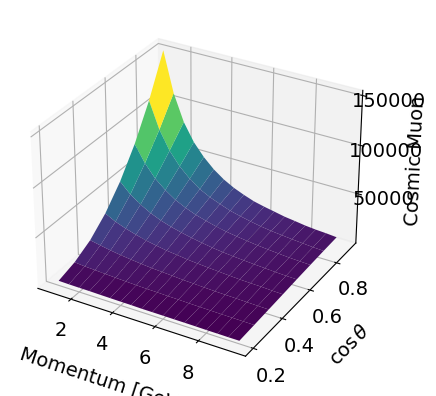

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
 
ax.plot_surface( p, costh, outHist[0], cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
ax.set_zlabel( r'Cosmic Muon', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

In [25]:
# Find the center point of each bin 
cosRefBin = np.arange(0.25, 1.05, 0.1)
pRefBin = np.arange(1.25, 10.25, 0.5)
cosRef, pRef = np.meshgrid(cosRefBin, pRefBin)
# cosRef, pRef
# dI_dpdcosth(cosRef, pRef)
cosRef.size, len(pRef)

(144, 18)

In [26]:
I = integrate.dblquad(dI_dpdcosth, 1., 10., 0.2, 1.)
norm = outHist[0].sum()*9*0.8/I[0]/(18*8)
outHist[0].sum()

2444262.0

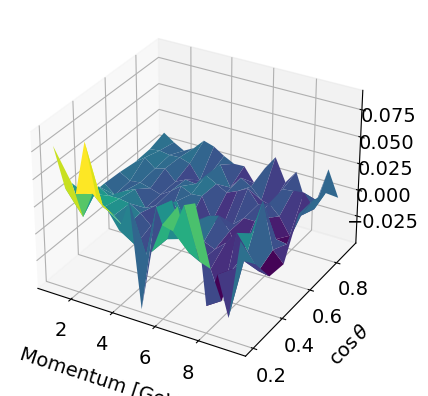

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

formula = dI_dpdcosth(cosRef, pRef)*norm
diff = (outHist[0] - formula)/formula
ax.plot_surface( p, costh, diff, cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
# ax.set_zlabel( r'Difference Raio', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

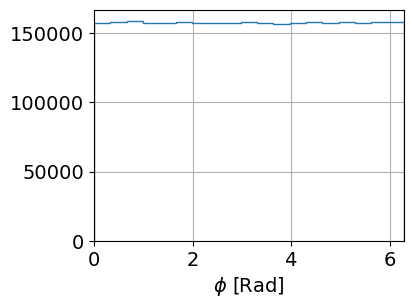

In [28]:
fig, ax = plt.subplots( figsize = (4, 3) )  

ax.hist(vcosmic[:,2], bins = np.linspace(0, 2*np.pi, 20), histtype = 'step')
ax.set_xlabel( r'$\phi$ [Rad]', fontsize = 14 )
# ax.set_ylabel( r'Cosmic muon flux [Hz]', fontsize = 16 )
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_xlim( [0, 2*np.pi])
# ax.set_ylim( [0, 1.1])

ax.grid(":")

In [29]:
len(vcosmic[:,2])

3000000

## Fill in a ROOT tree

In [30]:
import ROOT
from array import array

In [31]:
outfile = 'CosmicFlux.root'

In [32]:
f = ROOT.TFile(outfile, "RECREATE")
t = ROOT.TTree("kin", "Cosmic muons")

# Declare the variables
event = array( 'i', [0] )
vpdg = ROOT.std.vector('int')()
vE   = ROOT.std.vector('double')()
vpx  = ROOT.std.vector('double')()
vpy  = ROOT.std.vector('double')()
vpz  = ROOT.std.vector('double')()
vm   = ROOT.std.vector('double')()

# Set the branches
t.Branch('event', event, 'event/I')
t.Branch('pdg', vpdg)
t.Branch('E', vE)
t.Branch('px', vpx)
t.Branch('py', vpy)
t.Branch('pz', vpz)
t.Branch('m', vm)

# muon's constant
muPdg = 13
# unit: GeV
muMass = 0.105658

for iEvt in range(nEvents):
    
    vpdg.clear()
    vE.clear()
    vpx.clear()
    vpy.clear()
    vpz.clear()
    vm.clear()
    
    event[0] = iEvt
    
    for iCosmic in range(nCRperEvent):
        
        p, costh = cosmicsAll[allSelectedCosmicsIndex[iEvt][iCosmic]]
        phi = CosmicsPhi[iEvt][iCosmic]
        sinth = np.sqrt(1 - costh**2)
        
        E = np.sqrt( p**2 + muMass**2 )
        px = p*sinth*np.cos(phi)
        py = p*sinth*np.sin(phi)
        pz = -p*costh
        
        vpdg.push_back( muPdg )
        vE.push_back( E )
        vpx.push_back( px )
        vpy.push_back( py )
        vpz.push_back( pz )
        vm.push_back( muMass )
    
    t.Fill()

f.Write()
f.Close()        

## Validation

In [33]:
f = ROOT.TFile( outfile, 'READ')
t = f.Get("kin")
t

In [34]:
nEvents = t.GetEntries()

In [35]:
pL = []
costhL = []
phiL = []

In [36]:
for event in t:
    for i in range( nCRperEvent ):
        p = np.sqrt( event.px[i]**2 + event.py[i]**2 + event.pz[i]**2 )
        costh = -event.pz[i]/p
        phi = np.arctan( event.py[i]/event.px[i] )
        pL.append( p )
        costhL.append( costh )
        phiL.append( phi )

len(pL), len(costhL), len(phiL)

(3000000, 3000000, 3000000)

In [37]:
vp = np.array( pL )
vcosth = np.array( costhL )
vphi = np.array( phiL )

In [38]:
outHistROOT = np.histogram2d(vp, vcosth, bins = [18, 8], range = [[1., 10.], [0.2, 1]])

In [39]:
costh, p = np.meshgrid(outHistROOT[2][0:-1], outHistROOT[1][0:-1])

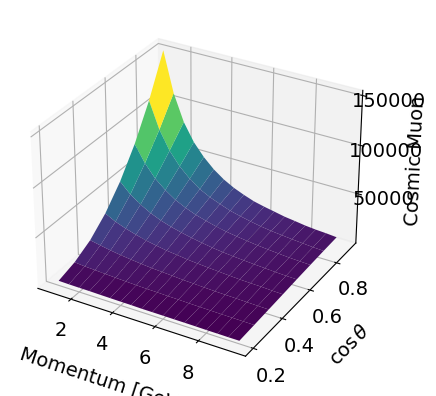

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
 
ax.plot_surface( p, costh, outHistROOT[0], cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
ax.set_zlabel( r'Cosmic Muon', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

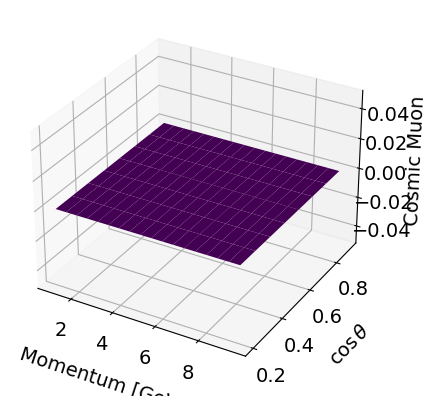

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
 
ax.plot_surface( p, costh, outHistROOT[0]-outHist[0], cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
ax.set_zlabel( r'Cosmic Muon', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

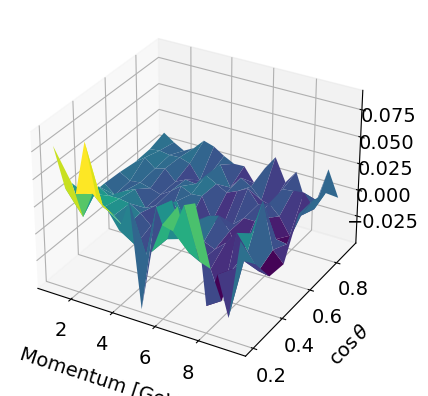

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

formula = dI_dpdcosth(cosRef, pRef)*norm
diff = (outHistROOT[0] - formula)/formula
ax.plot_surface( p, costh, diff, cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
# ax.set_zlabel( r'Difference Raio', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

In [43]:
outHist[0].sum()

2444262.0

In [44]:
Is[-1][0]/Is[:,0].sum()

0.1825878552517158

In [45]:
(3000-outHist[0].sum())/3000

-813.754